In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
parent_dir=""                            #to be changed if run on different computers

In [3]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPool2D
from tensorflow.keras.optimizers import Adam
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

# Random Gameplay:

In [4]:
env=gym.make("Pong-v0")                           #creates a cartpole game environment

In [5]:
observation=env.reset()
observation.shape

(210, 160, 3)

In [5]:
observation=observation.astype("float")/255

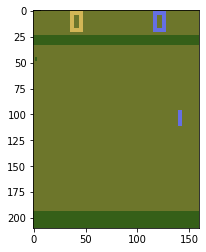

In [6]:
plt.imshow(observation)
plt.show()

In [7]:
env.observation_space

Box(210, 160, 3)

In [8]:
env.action_space

Discrete(6)

In [10]:
env.reset()
score=0
for t in range(1000):
    
    env.render()
    action=env.action_space.sample()
    
    observation,reward,done,other_info=env.step(action)
    score+=reward
    
    if done:
        print(reward)
        break
    
env.close()

In [11]:
class Agent:
    
    def __init__(self,obs_size,action_size):
        
        self.obs_size=obs_size                          #size of tuple used to define any state in the game
        self.action_size=action_size                    #no. of possible actions
        self.gamma=0.95                                 #discount factor
        self.memory=deque(maxlen=100000)                  
        #stores past experiences, experiences in the distant past will be discarded
        #when the memory is full and experiences in the recent past will be used
        
        self.epsilon=1                                  #exploration factor, intially we will do 100% exploration
        self.epsilon_decay=0.95                         #how much the exploration factor will decrease after episode
        self.epsilon_min=0.01                           #minimum value of epsilon
        self.lr=0.001                                   #learning_rate for SGD
        self.save_path=parent_dir+"pong.h5"
        self.model=self._create_model()
        
    def _create_model(self):
        
        model=Sequential()
        
        model.add(Conv2D(32,(3,3),activation="relu",padding="same",input_shape=self.obs_size))
        model.add(MaxPool2D((2,2)))
        model.add(Flatten())
        model.add(Dense(124,activation="relu"))
        model.add(Dense(self.action_size,activation="linear"))
        
        model.compile(optimizer=Adam(lr=self.lr),loss="mse")                      

#         model=self.load()
        
        return model
    
    def remember(self,cur_state,action,reward,next_state,done):
        self.memory.append((cur_state,action,reward,next_state,done))
    
    def act(self,state):
        
        if np.random.rand()<=self.epsilon:                                #exploration
            return random.randrange(self.action_size)#return random.sample(list(np.arange(self.action_size)),1)[0]
        
        action=np.argmax(self.model.predict(state)[0])
        return action                     #exploitation
    
    def fit(self,batch_size=32):                                           
        
        batch=random.sample(self.memory,batch_size)
        
        for cur_state,action,reward,next_state,done in batch:
            
            if done:
                y_true=reward
                
            else:
                y_true=reward+(self.gamma*np.amax(self.model.predict(next_state)[0]))
                
            target=self.model.predict(cur_state)
            target[0][action]=y_true
            
            self.model.fit(cur_state,target,epochs=1,verbose=0)
            
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
            
    def save(self):
        self.model.save(self.save_path)
        
    def load(self):
        return load_model(self.save_path)

In [12]:
env=gym.make("Pong-v0")                           #creates a MsPacman game environment

done=False
observation_size=env.observation_space.shape
action_size=env.action_space.n
batch_size=256

agent=Agent(action_size=action_size,obs_size=observation_size)
agent

W0824 12:00:12.492635 13980 deprecation.py:506] From c:\users\akshay\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
for episode in range(500):
    
    state=env.reset()                                 #intial state for each episode
    state=np.reshape(state,(1,observation_size[0],observation_size[1],observation_size[2]))
    state=state.astype("float")/255

    score=0
    
    for t in range(10000):
        
        action=agent.act(state)
        next_state,reward,done,other_info=env.step(action)
        score+=reward
        
        next_state=np.reshape(next_state,(1,observation_size[0],observation_size[1],observation_size[2]))
        next_state=next_state.astype("float")/255
        
        agent.remember(cur_state=state,action=action,reward=reward,next_state=next_state,done=done)
        state=next_state
        
        if done:
            print("Episode: ",episode," Score: ",score," Exploration factor: ",agent.epsilon)
            break
    
    if len(agent.memory)>=batch_size:
        agent.fit(batch_size)
        
agent.save()
env.close()

Episode:  0  Score:  -21.0  Exploration factor:  1
Episode:  1  Score:  -18.0  Exploration factor:  0.95
Episode:  2  Score:  -21.0  Exploration factor:  0.9025
Episode:  3  Score:  -21.0  Exploration factor:  0.8573749999999999
Episode:  4  Score:  -20.0  Exploration factor:  0.8145062499999999
Episode:  5  Score:  -20.0  Exploration factor:  0.7737809374999999
Episode:  6  Score:  -21.0  Exploration factor:  0.7350918906249998
Episode:  7  Score:  -21.0  Exploration factor:  0.6983372960937497
Episode:  8  Score:  -21.0  Exploration factor:  0.6634204312890623
Episode:  9  Score:  -21.0  Exploration factor:  0.6302494097246091
Episode:  10  Score:  -21.0  Exploration factor:  0.5987369392383786
Episode:  11  Score:  -21.0  Exploration factor:  0.5688000922764596
Episode:  12  Score:  -20.0  Exploration factor:  0.5403600876626365
